In [1]:
import pandas as pd
import re 
import seaborn as sns; sns.set()
df = pd.read_csv('eas.csv')
df.head()

,date,CSC Qty 505,CINN Qty 505,CLE Qty 505,IND Qty 505,Pitt Qty 505,Chain Wide 505,CSC Qty 600,CINN Qty 600,CLE Qty 600,Ind Qty 600,PITT Qty 600,Advertising Spending
0,12-23-2006,18,54,48,60,37,3215,216,361,359,558,255,No
1,12-30-2006,1,6,2,1,21,888,51,80,54,92,82,No
2,01-06-2006,3,1,2,2,7,389,28,69,122,91,84,No
3,01-13-2006,2,0,6,11,1,532,21,47,96,78,99,No
4,01-20-2006,2,10,19,24,14,1105,21,82,104,99,101,No


In [2]:
dates = pd.to_datetime(df['date'], format = "%m-%d-%Y")

In [3]:
df.head()
df['date'] = df['date']

In [4]:
df.columns = [re.sub(' +', ' ', x) for x in df.columns]


In [5]:
cities = df.drop(["Chain Wide 505", "Advertising Spending"], axis =1)
cities.head()

,date,CSC Qty 505,CINN Qty 505,CLE Qty 505,IND Qty 505,Pitt Qty 505,CSC Qty 600,CINN Qty 600,CLE Qty 600,Ind Qty 600,PITT Qty 600
0,12-23-2006,18,54,48,60,37,216,361,359,558,255
1,12-30-2006,1,6,2,1,21,51,80,54,92,82
2,01-06-2006,3,1,2,2,7,28,69,122,91,84
3,01-13-2006,2,0,6,11,1,21,47,96,78,99
4,01-20-2006,2,10,19,24,14,21,82,104,99,101


In [6]:
cities5 = cities[[x for x in cities.columns if '5' in x]]
cities6 = cities[[x for x in cities.columns if '6' in x]]

In [7]:
seasonal = cities6/cities6.mean()
seasonal.head()

,CSC Qty 600,CINN Qty 600,CLE Qty 600,Ind Qty 600,PITT Qty 600
0,4.201297,2.942554,1.804020,3.570384,1.987505
1,0.991973,0.652090,0.271357,0.588665,0.639119
2,0.544613,0.562427,0.613065,0.582267,0.654707
3,0.408459,0.383103,0.482412,0.499086,0.771619
4,0.408459,0.668392,0.522613,0.633455,0.787208


In [8]:
adjusted = pd.DataFrame(cities5.values/seasonal.values, columns = cities5.columns)
adjusted['date'] = df['date']
adjusted_melt = pd.melt(adjusted, id_vars=['date'], value_vars=[x for x in adjusted.columns if x !='date'])
adjusted_melt.head()

,date,variable,value
0,12-23-2006,CSC Qty 505,4.284392
1,12-30-2006,CSC Qty 505,1.008092
2,01-06-2006,CSC Qty 505,5.508503
3,01-13-2006,CSC Qty 505,4.896447
4,01-20-2006,CSC Qty 505,4.896447


In [9]:
avg = pd.DataFrame((adjusted.loc[:, ~adjusted.columns.isin(['date', 'CINN Qty 505'])] / .006).mean(axis = 1), columns=['avg'])
avg['Cin'] = adjusted['CINN Qty 505']/.007
avg["date"] = adjusted["date"]
avg_melt = pd.melt(avg, id_vars=['date'], value_vars=[x for x in avg.columns if x !='date'])
avg_melt.head()

,date,variable,value
0,12-23-2006,avg,2763.035756
1,12-30-2006,avg,1788.955993
2,01-06-2006,avg,954.060345
3,01-13-2006,avg,1694.592339
4,01-20-2006,avg,4038.501709


In [10]:
percent_diff = pd.DataFrame(avg.apply(lambda x: (x['avg'] - x['Cin'])/((x['avg'] + x['Cin'])/2)*100, axis=1), columns=['Percent Difference'])

percent_diff['date'] = avg['date']
percent_diff.head()

,Percent Difference,date
0,5.252193,12-23-2006
1,30.579262,12-30-2006
2,115.897949,01-06-2006
3,200.000000,01-13-2006
4,61.568268,01-20-2006


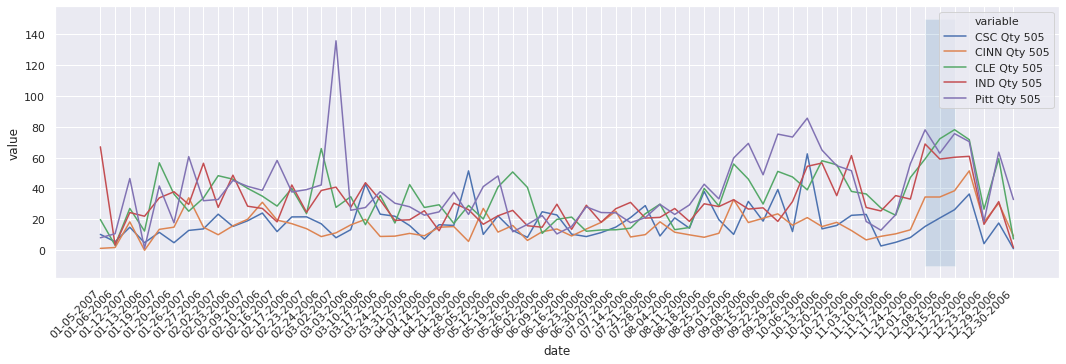

In [11]:

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
plt.figure(figsize=(18,5))
ax = sns.lineplot(x="date", y="value", hue="variable", data=adjusted_melt)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    #fontweight='light',
    #fontsize='small'  
)

ax.fill_between(avg["date"].iloc[49:52], -10, 150, facecolor='steelblue', alpha=0.2,
                label='1 sigma range')

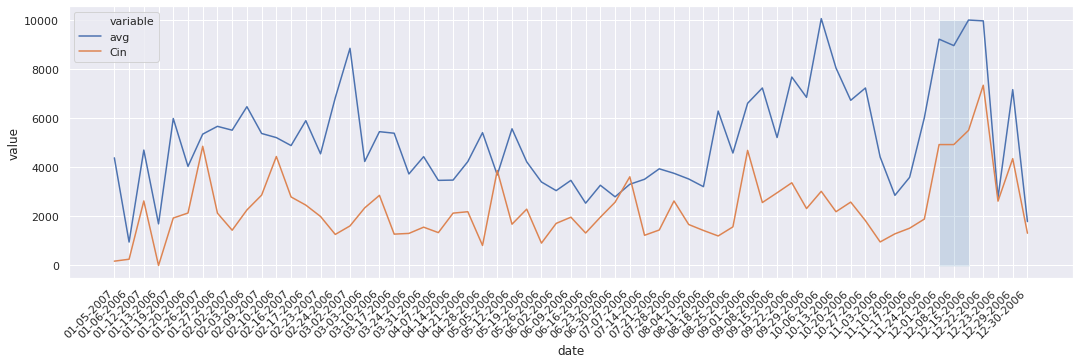

In [12]:
plt.figure(figsize=(18,5))
ax = sns.lineplot(x="date", y="value", hue="variable", data=avg_melt)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    #fontweight='light',
    #fontsize='small'  
)


ax.fill_between(avg["date"].iloc[49:52], -10, 10000, facecolor='steelblue', alpha=0.2,
                label='1 sigma range')

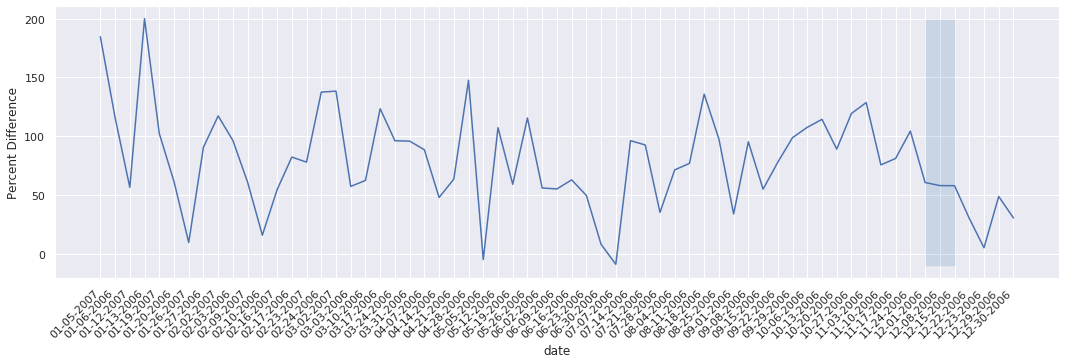

In [13]:
plt.figure(figsize=(18,5))
ax = sns.lineplot(x="date", y="Percent Difference", data=percent_diff)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    #fontweight='light',
    #fontsize='small'  
)


ax.fill_between(avg["date"].iloc[49:52], -10, 200, facecolor='steelblue', alpha=0.2,
                label='1 sigma range')

In [14]:
from statsmodels.formula.api import ols


df = pd.read_csv("bs.csv")

crazy = df[["SPAGHETTY COLOR CRAZY AZ", "SPAGHETTY COLOR CRAZY CA"]]
crazy_melted = pd.melt(crazy, value_vars=crazy.columns)
crazy_melted['bin'] = crazy_melted.apply(lambda x: 1 if x['variable'] == "SPAGHETTY COLOR CRAZY AZ" else 0, axis = 1)

In [15]:
results = ols('value ~ bin', data=crazy_melted).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     29.39
Date:                Sat, 09 Nov 2019   Prob (F-statistic):           1.42e-06
Time:                        14:17:43   Log-Likelihood:                -144.09
No. Observations:                  56   AIC:                             292.2
Df Residuals:                      54   BIC:                             296.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0714      0.610      1.756      0.0

In [16]:
df.head()

,date,SPAGHETTY COLOR CRAZY AZ,SPAGHETTY COLOR CRAZY CA,SPAGHETTY GO GO GLAM AZ,SPAGHETTY GO GO GLAM CA
0,2007-06-17,0,0,0,0
1,2007-06-18,1,0,0,0
2,2007-06-19,3,0,5,1
3,2007-06-20,1,0,7,3
4,2007-06-21,1,0,15,2


In [17]:
df.mean()

SPAGHETTY COLOR CRAZY AZ    5.750000
SPAGHETTY COLOR CRAZY CA    1.071429
 SPAGHETTY GO GO GLAM AZ    7.357143
 SPAGHETTY GO GO GLAM CA    3.964286
dtype: float64

In [18]:
glam = df[[" SPAGHETTY GO GO GLAM AZ"," SPAGHETTY GO GO GLAM CA"]]
glam_melted = pd.melt(glam, value_vars=glam.columns)
glam_melted['bin'] = glam_melted.apply(lambda x: 1 if x['variable'] == " SPAGHETTY GO GO GLAM AZ" else 0, axis = 1)

results = ols('value ~ bin', data=glam_melted).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     9.676
Date:                Sat, 09 Nov 2019   Prob (F-statistic):            0.00298
Time:                        14:17:43   Log-Likelihood:                -157.20
No. Observations:                  56   AIC:                             318.4
Df Residuals:                      54   BIC:                             322.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9643      0.771      5.140      0.0